Koherensi LDA Semua Bintang

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')

# Load data
texts = df['ulasan'].dropna().astype(str).tolist()

# Tokenisasi
tokenized_reviews = [text.split() for text in texts]

# Membuat dictionary dan corpus untuk LDA
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Mencoba berbagai jumlah topik
topic_range = range(2, 40)  # Coba dari 2 hingga 40 topik
coherence_scores = []

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model_lda.get_coherence())

# Menggunakan 10 topik secara langsung
num_topics = 10
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Menghitung coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f'Jumlah Topik: {num_topics}, Coherence Score: {coherence_score}')

# Visualisasi topik LDA dengan 10 topik
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)
# Plot hasilnya
plt.figure(figsize=(10,5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-')
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.title("Coherence Score untuk Berbagai Jumlah Topik")
plt.grid(True)
plt.show()


Saving whatsapp_appstore.csv to whatsapp_appstore (1).csv


NMF Semua Bintang

Saving whatsapp_appstore.csv to whatsapp_appstore (3).csv
Jumlah Topik: 3, Coherence Score: 0.5566
Tabel Hasil Topik:
  Topik 0 Topik 1   Topik 2
0   kasih   masuk       gak
1     blm     gak     mohon
2    pink  muncul     kasih
3   dapet    buka    iphone
4   ganti     ios     versi
5   fitur      ai       ios
6   warna      ga  aplikasi
7  bubble    meta   terbaru
8    chat  update      tema
9    tema      wa  whatsapp


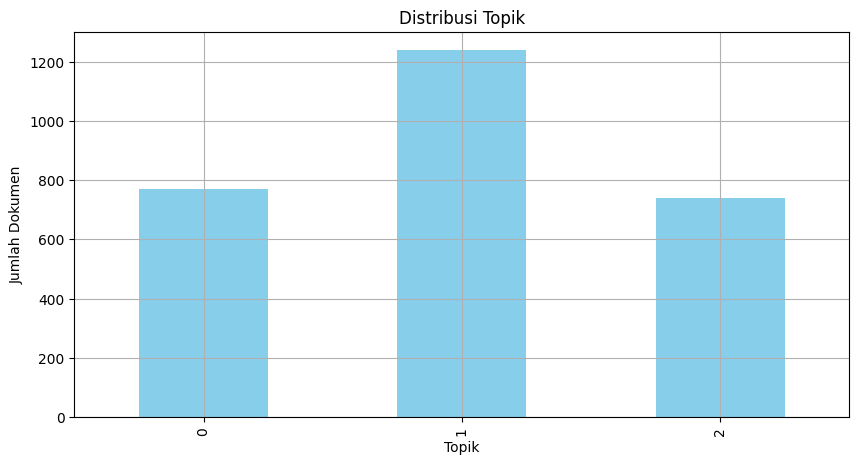

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

# Mengunggah file
uploaded = files.upload()

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')

# Periksa apakah ada nilai NaN
df['ulasan'] = df['ulasan'].fillna("")  # Mengganti NaN dengan string kosong

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=5000)
tfidf = vectorizer.fit_transform(df['ulasan'])
feature_names = vectorizer.get_feature_names_out()

# Tokenisasi untuk Gensim
tokenized_reviews = [text.split() for text in df['ulasan']]
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Tetapkan jumlah topik menjadi 3
n_topics = 3

# Fit NMF dengan 3 topik
nmf = NMF(n_components=n_topics, random_state=42, max_iter=1000, init='nndsvd')
W = nmf.fit_transform(tfidf)
H = nmf.components_

# Ekstrak kata topik
top_words = [[feature_names[i] for i in topic.argsort()[-10:]] for topic in H]

# Coherence Score dari Gensim
coherence_model = CoherenceModel(topics=top_words, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f'Jumlah Topik: {n_topics}, Coherence Score: {coherence_score:.4f}')

# Tampilkan topik
topics = {f"Topik {i}": [feature_names[idx] for idx in topic.argsort()[-10:]] for i, topic in enumerate(H)}
topics_df = pd.DataFrame(topics)
print("Tabel Hasil Topik:")
print(topics_df)

# Distribusi Topik
df['Dominant_Topic'] = W.argmax(axis=1)
topic_counts = df['Dominant_Topic'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
topic_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Topik')
plt.ylabel('Jumlah Dokumen')
plt.title('Distribusi Topik')
plt.grid()
plt.show()


Bertopic Semua Bintang


In [ ]:

import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')
texts = df['ulasan'].dropna().astype(str).tolist()

# Load model transformer untuk embedding
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Vectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2))

# Tetapkan jumlah topik menjadi 3
nr_topics = 3

try:
    # Inisialisasi dan fit BERTopic dengan 3 topik
    model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model, nr_topics=nr_topics)
    topics, probs = model.fit_transform(texts)

    # Ambil topik dan validasi jumlah topik
    topic_freq = model.get_topic_freq()
    actual_topics = len(topic_freq[topic_freq['Topic'] != -1])  # Hitung jumlah topik valid (exclude -1)

    if actual_topics < 1:
        print(f"Jumlah topik tidak valid.")
    else:
        # Persiapkan data untuk CoherenceModel
        topic_words = model.get_topics()
        topic_list = [[word for word, _ in words] for topic_id, words in topic_words.items() if topic_id != -1]
        texts_tokenized = [text.split() for text in texts]
        dictionary = Dictionary(texts_tokenized)

        # Hitung coherence score
        coherence_model = CoherenceModel(topics=topic_list, texts=texts_tokenized, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print(f'Jumlah Topik: {nr_topics}, Coherence Score: {coherence_score}')

        # Visualisasi distribusi topik
        model.visualize_topics()

        # Visualisasi distribusi dokumen per topik
        topic_distribution = pd.DataFrame({'Topic': topics, 'Text': texts})
        topic_counts = topic_distribution['Topic'].value_counts()

        if not topic_counts.empty:
            plt.figure(figsize=(10, 5))
            topic_counts.plot(kind='bar', color='skyblue')
            plt.xlabel('Topik')
            plt.ylabel('Jumlah Dokumen')
            plt.title('Distribusi Topik dalam Dokumen')
            plt.grid(True)
            plt.show()
        else:
            print("Tidak ada topik yang ditemukan untuk divisualisasikan.")

except ValueError as e:
    print(f"Error: {e}")


Jumlah Topik: 3, Coherence Score: 0.41185229301701975
Error: zero-size array to reduction operation maximum which has no identity


Per Rating LDA


Saving whatsapp_appstore.csv to whatsapp_appstore (1).csv
Proses untuk Rating 3
Rating: 3, Jumlah Topik: 1, Coherence Score: 0.20823487876125185
Rating: 3, Jumlah Topik: 2, Coherence Score: 0.3068835188387955
Rating: 3, Jumlah Topik: 3, Coherence Score: 0.31411765322491203
Rating: 3, Jumlah Topik: 4, Coherence Score: 0.3090400529119342
Rating: 3, Jumlah Topik: 5, Coherence Score: 0.33928228106146197
Rating: 3, Jumlah Topik: 6, Coherence Score: 0.35878884694517604
Rating: 3, Jumlah Topik: 7, Coherence Score: 0.3712293952580933
Rating: 3, Jumlah Topik: 8, Coherence Score: 0.36549324621155627
Rating: 3, Jumlah Topik: 9, Coherence Score: 0.3713965987695833
Rating: 3, Jumlah Topik: 10, Coherence Score: 0.3894505588462193
Rating: 3, Jumlah Topik: 11, Coherence Score: 0.3902033342521825
Rating: 3, Jumlah Topik: 12, Coherence Score: 0.41022977986838827
Rating: 3, Jumlah Topik: 13, Coherence Score: 0.4006672121985208
Rating: 3, Jumlah Topik: 14, Coherence Score: 0.38820351403132447
Rating: 3, J

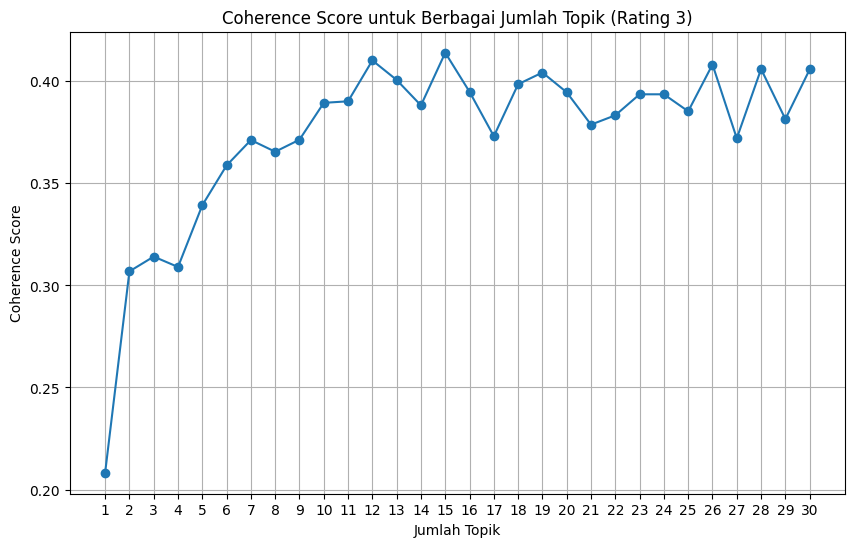

Jumlah Topik Optimal untuk Rating 3: 15 dengan Coherence Score: 0.4140043973300859
Proses untuk Rating 1
Rating: 1, Jumlah Topik: 1, Coherence Score: 0.25342558950841865
Rating: 1, Jumlah Topik: 2, Coherence Score: 0.21924178656419344
Rating: 1, Jumlah Topik: 3, Coherence Score: 0.24318709236348882
Rating: 1, Jumlah Topik: 4, Coherence Score: 0.2541961420772372
Rating: 1, Jumlah Topik: 5, Coherence Score: 0.2753684576907991
Rating: 1, Jumlah Topik: 6, Coherence Score: 0.28402986552681253
Rating: 1, Jumlah Topik: 7, Coherence Score: 0.29940552788066643
Rating: 1, Jumlah Topik: 8, Coherence Score: 0.2926856856663783
Rating: 1, Jumlah Topik: 9, Coherence Score: 0.3129020409741557
Rating: 1, Jumlah Topik: 10, Coherence Score: 0.3222853302280194
Rating: 1, Jumlah Topik: 11, Coherence Score: 0.31811563096810613
Rating: 1, Jumlah Topik: 12, Coherence Score: 0.30063455021789076
Rating: 1, Jumlah Topik: 13, Coherence Score: 0.33073966210489536
Rating: 1, Jumlah Topik: 14, Coherence Score: 0.325

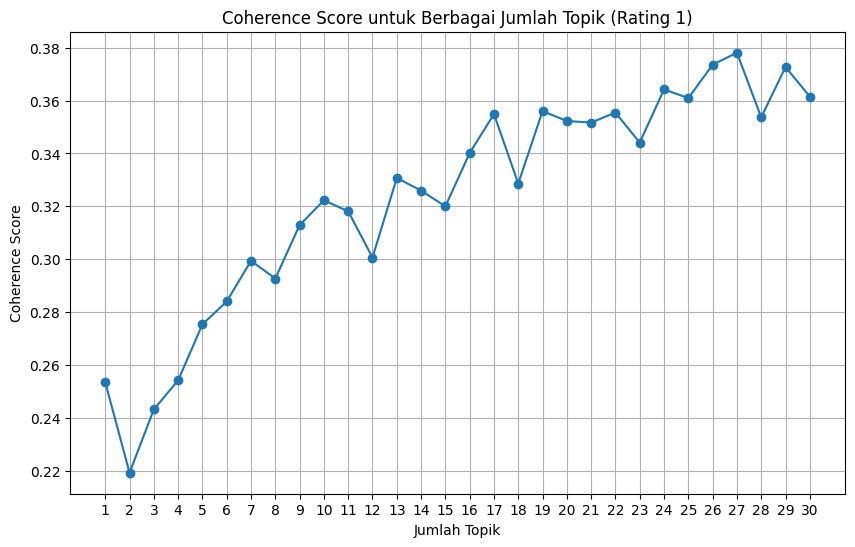

Jumlah Topik Optimal untuk Rating 1: 27 dengan Coherence Score: 0.37810864163165747
Proses untuk Rating 5
Rating: 5, Jumlah Topik: 1, Coherence Score: 0.3148123190891331
Rating: 5, Jumlah Topik: 2, Coherence Score: 0.312376164217857
Rating: 5, Jumlah Topik: 3, Coherence Score: 0.39124950356821936
Rating: 5, Jumlah Topik: 4, Coherence Score: 0.4291028998902027
Rating: 5, Jumlah Topik: 5, Coherence Score: 0.4610636064104085
Rating: 5, Jumlah Topik: 6, Coherence Score: 0.4439876868648136
Rating: 5, Jumlah Topik: 7, Coherence Score: 0.4470155120763149
Rating: 5, Jumlah Topik: 8, Coherence Score: 0.443697705233824
Rating: 5, Jumlah Topik: 9, Coherence Score: 0.4530387585646124
Rating: 5, Jumlah Topik: 10, Coherence Score: 0.4605202899920961
Rating: 5, Jumlah Topik: 11, Coherence Score: 0.44680422778936557
Rating: 5, Jumlah Topik: 12, Coherence Score: 0.4605719659095262
Rating: 5, Jumlah Topik: 13, Coherence Score: 0.4496492832131527
Rating: 5, Jumlah Topik: 14, Coherence Score: 0.4374259318

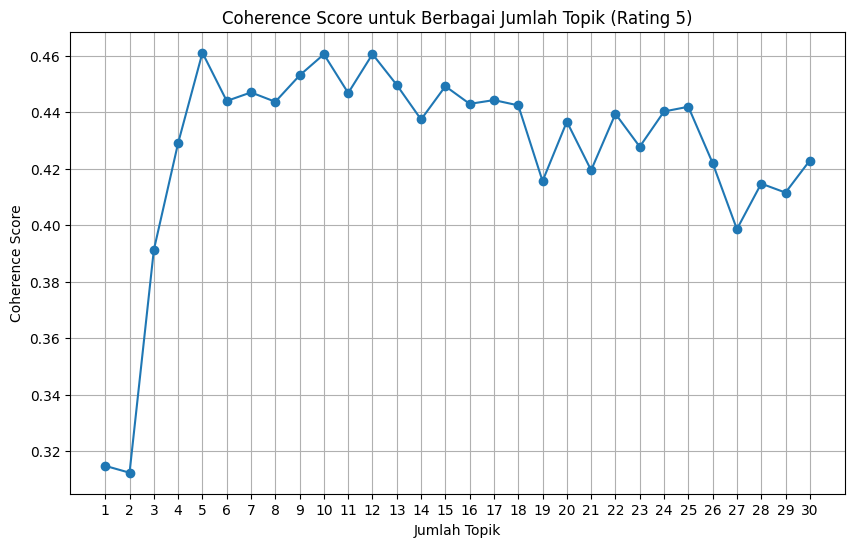

Jumlah Topik Optimal untuk Rating 5: 5 dengan Coherence Score: 0.4610636064104085
Proses untuk Rating 2
Rating: 2, Jumlah Topik: 1, Coherence Score: 0.2570694643520216
Rating: 2, Jumlah Topik: 2, Coherence Score: 0.271263795715608
Rating: 2, Jumlah Topik: 3, Coherence Score: 0.33082947194335655
Rating: 2, Jumlah Topik: 4, Coherence Score: 0.35885944687698
Rating: 2, Jumlah Topik: 5, Coherence Score: 0.3382897892923139
Rating: 2, Jumlah Topik: 6, Coherence Score: 0.38094299727468517
Rating: 2, Jumlah Topik: 7, Coherence Score: 0.37027883926217375
Rating: 2, Jumlah Topik: 8, Coherence Score: 0.3915688286642143
Rating: 2, Jumlah Topik: 9, Coherence Score: 0.4179624448979953
Rating: 2, Jumlah Topik: 10, Coherence Score: 0.40596331507683125
Rating: 2, Jumlah Topik: 11, Coherence Score: 0.4169100758118859
Rating: 2, Jumlah Topik: 12, Coherence Score: 0.4302742935026765
Rating: 2, Jumlah Topik: 13, Coherence Score: 0.4187135559771692
Rating: 2, Jumlah Topik: 14, Coherence Score: 0.39820646701

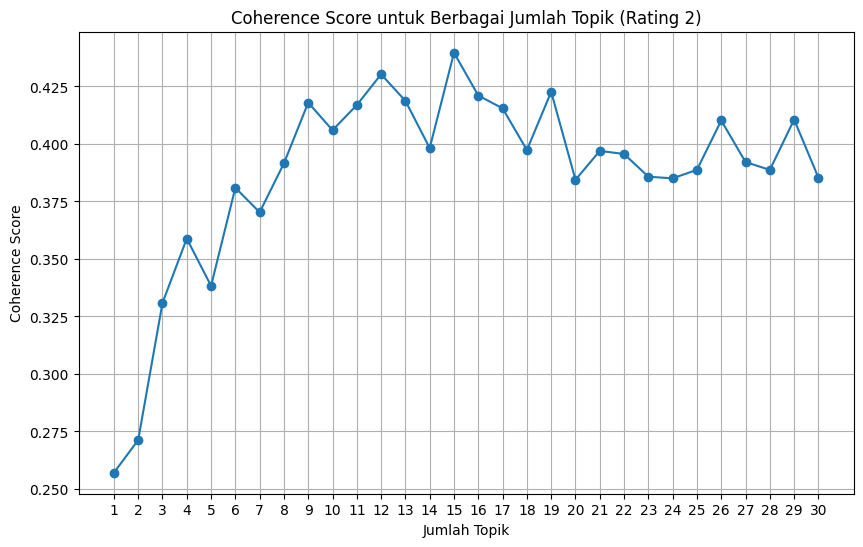

Jumlah Topik Optimal untuk Rating 2: 15 dengan Coherence Score: 0.4396421486915462
Proses untuk Rating 4
Rating: 4, Jumlah Topik: 1, Coherence Score: 0.2472907131556032
Rating: 4, Jumlah Topik: 2, Coherence Score: 0.30060634367619615
Rating: 4, Jumlah Topik: 3, Coherence Score: 0.39931243155297347
Rating: 4, Jumlah Topik: 4, Coherence Score: 0.37506501242214224
Rating: 4, Jumlah Topik: 5, Coherence Score: 0.3903097187023532
Rating: 4, Jumlah Topik: 6, Coherence Score: 0.36925235757391767
Rating: 4, Jumlah Topik: 7, Coherence Score: 0.41655055155572684
Rating: 4, Jumlah Topik: 8, Coherence Score: 0.4167360824379925
Rating: 4, Jumlah Topik: 9, Coherence Score: 0.4325968450976543
Rating: 4, Jumlah Topik: 10, Coherence Score: 0.42559982970710963
Rating: 4, Jumlah Topik: 11, Coherence Score: 0.4311705667123442
Rating: 4, Jumlah Topik: 12, Coherence Score: 0.4085665236843459
Rating: 4, Jumlah Topik: 13, Coherence Score: 0.41736099570737595
Rating: 4, Jumlah Topik: 14, Coherence Score: 0.4351

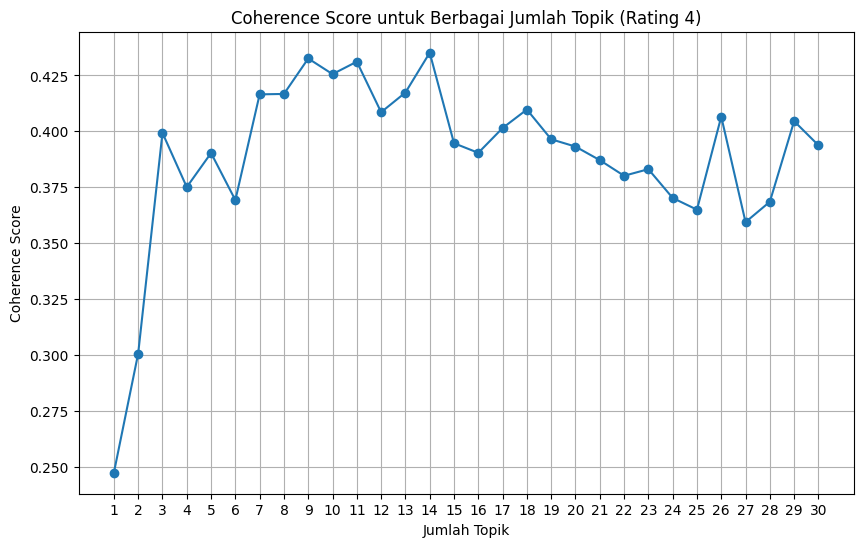

Jumlah Topik Optimal untuk Rating 4: 14 dengan Coherence Score: 0.43517671905430527


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')

# Mengelompokkan ulasan berdasarkan rating
ratings = df['rating'].unique()
df['ulasan'] = df['ulasan'].astype(str)

# Proses per rating
for rating in ratings:
    print(f"Proses untuk Rating {rating}")

    # Memfilter ulasan berdasarkan rating
    df_rating = df[df['rating'] == rating]

    # Tokenisasi
    texts = df_rating['ulasan'].dropna().astype(str).tolist()
    tokenized_reviews = [text.split() for text in texts]

    # Membuat dictionary dan corpus
    dictionary = corpora.Dictionary(tokenized_reviews)
    corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

    # Mencari jumlah topik optimal menggunakan coherence score
    coherence_scores = []
    topic_range = range(1, 31)

    for num_topics in topic_range:
        # Membuat LDA model untuk mendapatkan topik
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

        # Menghitung koherensi berdasarkan model LDA
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f'Rating: {rating}, Jumlah Topik: {num_topics}, Coherence Score: {coherence_score}')

    # Visualisasi coherence score
    topics, scores = zip(*coherence_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(topics, scores, marker='o')
    plt.xticks(topics)
    plt.title(f'Coherence Score untuk Berbagai Jumlah Topik (Rating {rating})')
    plt.xlabel('Jumlah Topik')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Menampilkan jumlah topik optimal
    optimal_topics = max(coherence_scores, key=lambda x: x[1])
    print(f'Jumlah Topik Optimal untuk Rating {rating}: {optimal_topics[0]} dengan Coherence Score: {optimal_topics[1]}')


NMF per rating

Saving whatsapp_appstore.csv to whatsapp_appstore (1).csv
Proses untuk Rating 3
Rating: 3, Jumlah Topik: 1, Coherence Score: 0.4183204083603152
Rating: 3, Jumlah Topik: 2, Coherence Score: 0.4082993491375849
Rating: 3, Jumlah Topik: 3, Coherence Score: 0.39057532041254106
Rating: 3, Jumlah Topik: 4, Coherence Score: 0.4090624442633515
Rating: 3, Jumlah Topik: 5, Coherence Score: 0.38894857071038286
Rating: 3, Jumlah Topik: 6, Coherence Score: 0.41327979417614014
Rating: 3, Jumlah Topik: 7, Coherence Score: 0.41632326317969587
Rating: 3, Jumlah Topik: 8, Coherence Score: 0.4038219403464471
Rating: 3, Jumlah Topik: 9, Coherence Score: 0.41130594348545024
Rating: 3, Jumlah Topik: 10, Coherence Score: 0.41583470469445294
Rating: 3, Jumlah Topik: 11, Coherence Score: 0.41878428895199504
Rating: 3, Jumlah Topik: 12, Coherence Score: 0.3886960153322283
Rating: 3, Jumlah Topik: 13, Coherence Score: 0.4080022493173888
Rating: 3, Jumlah Topik: 14, Coherence Score: 0.41027785858765126
Rating: 3, 

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 3, Jumlah Topik: 17, Coherence Score: 0.40222229843156615
Rating: 3, Jumlah Topik: 18, Coherence Score: 0.39524955300854736
Rating: 3, Jumlah Topik: 19, Coherence Score: 0.3984252231579444
Rating: 3, Jumlah Topik: 20, Coherence Score: 0.40043197410919396
Rating: 3, Jumlah Topik: 21, Coherence Score: 0.4031774804869479
Rating: 3, Jumlah Topik: 22, Coherence Score: 0.4060453285576004
Rating: 3, Jumlah Topik: 23, Coherence Score: 0.4066841201990522
Rating: 3, Jumlah Topik: 24, Coherence Score: 0.40723210354782663


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 3, Jumlah Topik: 25, Coherence Score: 0.3980682276941019
Rating: 3, Jumlah Topik: 26, Coherence Score: 0.40131689472350984
Rating: 3, Jumlah Topik: 27, Coherence Score: 0.39946909640304223
Rating: 3, Jumlah Topik: 28, Coherence Score: 0.41697806461045717
Rating: 3, Jumlah Topik: 29, Coherence Score: 0.4009366129197272
Rating: 3, Jumlah Topik: 30, Coherence Score: 0.40110824202167206


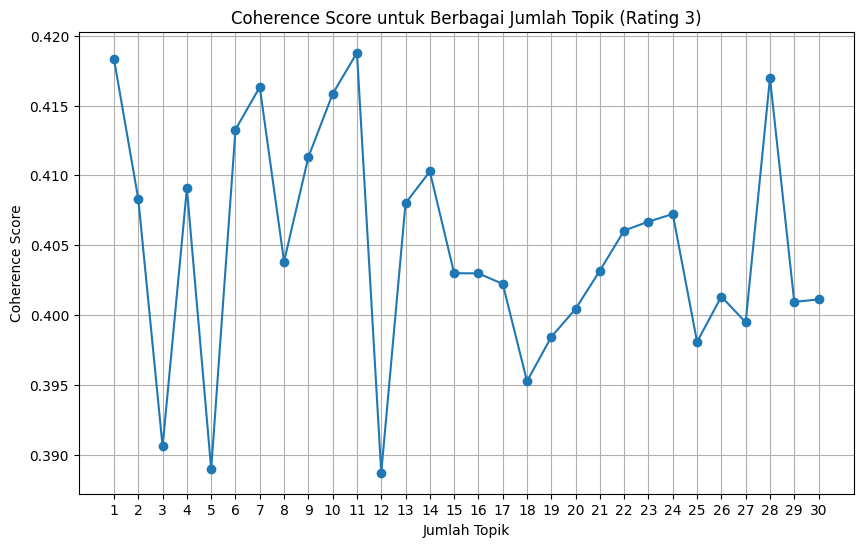

Jumlah Topik Optimal untuk Rating 3: 11 dengan Coherence Score: 0.41878428895199504
Proses untuk Rating 1
Rating: 1, Jumlah Topik: 1, Coherence Score: 0.42122747592905974
Rating: 1, Jumlah Topik: 2, Coherence Score: 0.4400541105574698
Rating: 1, Jumlah Topik: 3, Coherence Score: 0.45619394824840126
Rating: 1, Jumlah Topik: 4, Coherence Score: 0.458968781233499
Rating: 1, Jumlah Topik: 5, Coherence Score: 0.41553983208959755
Rating: 1, Jumlah Topik: 6, Coherence Score: 0.42159268582363246
Rating: 1, Jumlah Topik: 7, Coherence Score: 0.4186403800338166
Rating: 1, Jumlah Topik: 8, Coherence Score: 0.39611127238924226
Rating: 1, Jumlah Topik: 9, Coherence Score: 0.41844818139851525
Rating: 1, Jumlah Topik: 10, Coherence Score: 0.4082431771277344
Rating: 1, Jumlah Topik: 11, Coherence Score: 0.4271612816088597
Rating: 1, Jumlah Topik: 12, Coherence Score: 0.4246301984300131
Rating: 1, Jumlah Topik: 13, Coherence Score: 0.4285682183892705
Rating: 1, Jumlah Topik: 14, Coherence Score: 0.41386

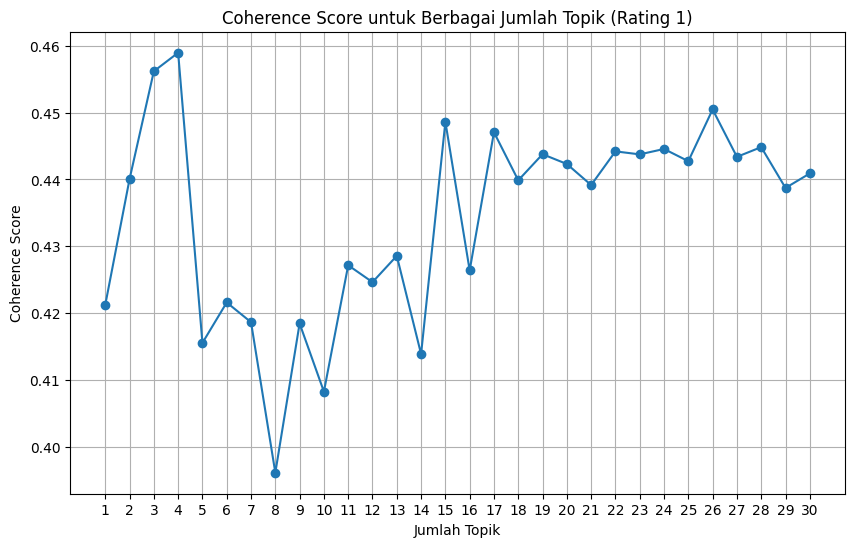

Jumlah Topik Optimal untuk Rating 1: 4 dengan Coherence Score: 0.458968781233499
Proses untuk Rating 5
Rating: 5, Jumlah Topik: 1, Coherence Score: 0.5013097782503749
Rating: 5, Jumlah Topik: 2, Coherence Score: 0.5329336294316791
Rating: 5, Jumlah Topik: 3, Coherence Score: 0.49904740847741014
Rating: 5, Jumlah Topik: 4, Coherence Score: 0.4837796359975145
Rating: 5, Jumlah Topik: 5, Coherence Score: 0.46418705565064544
Rating: 5, Jumlah Topik: 6, Coherence Score: 0.4728008434141935
Rating: 5, Jumlah Topik: 7, Coherence Score: 0.42207260438276367
Rating: 5, Jumlah Topik: 8, Coherence Score: 0.42868296568927644
Rating: 5, Jumlah Topik: 9, Coherence Score: 0.42329843158183506
Rating: 5, Jumlah Topik: 10, Coherence Score: 0.4304302071767042
Rating: 5, Jumlah Topik: 11, Coherence Score: 0.38216222998179783
Rating: 5, Jumlah Topik: 12, Coherence Score: 0.3882328540378619
Rating: 5, Jumlah Topik: 13, Coherence Score: 0.39173682210791144
Rating: 5, Jumlah Topik: 14, Coherence Score: 0.390483

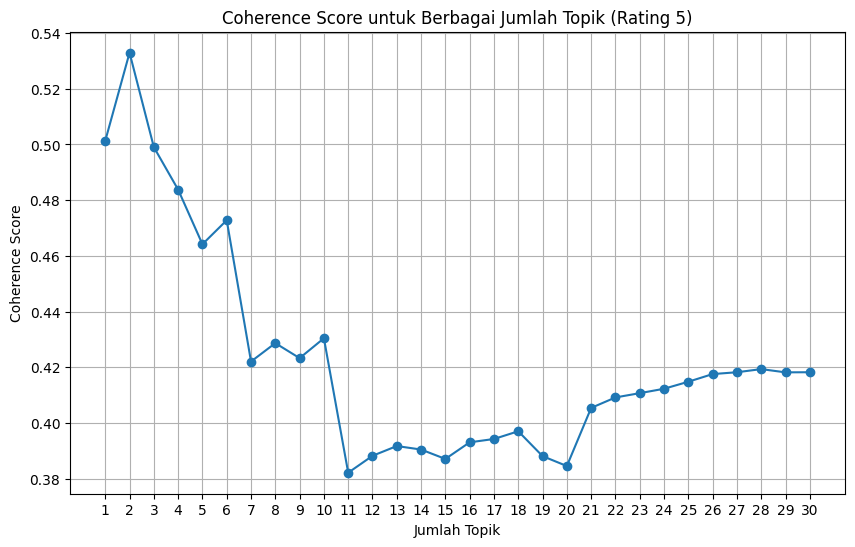

Jumlah Topik Optimal untuk Rating 5: 2 dengan Coherence Score: 0.5329336294316791
Proses untuk Rating 2
Rating: 2, Jumlah Topik: 1, Coherence Score: 0.4531431003763943
Rating: 2, Jumlah Topik: 2, Coherence Score: 0.41891172524511994
Rating: 2, Jumlah Topik: 3, Coherence Score: 0.42384435948233157
Rating: 2, Jumlah Topik: 4, Coherence Score: 0.4841465648856591
Rating: 2, Jumlah Topik: 5, Coherence Score: 0.48181478570334146
Rating: 2, Jumlah Topik: 6, Coherence Score: 0.46892263474546425
Rating: 2, Jumlah Topik: 7, Coherence Score: 0.45834522487797946
Rating: 2, Jumlah Topik: 8, Coherence Score: 0.4384057474906221
Rating: 2, Jumlah Topik: 9, Coherence Score: 0.44659031316016545
Rating: 2, Jumlah Topik: 10, Coherence Score: 0.4139660568113833
Rating: 2, Jumlah Topik: 11, Coherence Score: 0.4132917437296586
Rating: 2, Jumlah Topik: 12, Coherence Score: 0.4007126464328587
Rating: 2, Jumlah Topik: 13, Coherence Score: 0.38082341700355854


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 2, Jumlah Topik: 14, Coherence Score: 0.39332583435918883
Rating: 2, Jumlah Topik: 15, Coherence Score: 0.38661748818470426
Rating: 2, Jumlah Topik: 16, Coherence Score: 0.3915598047978237
Rating: 2, Jumlah Topik: 17, Coherence Score: 0.3733502319806326
Rating: 2, Jumlah Topik: 18, Coherence Score: 0.3921309037739085
Rating: 2, Jumlah Topik: 19, Coherence Score: 0.36833692370045484
Rating: 2, Jumlah Topik: 20, Coherence Score: 0.38234069505463136
Rating: 2, Jumlah Topik: 21, Coherence Score: 0.38714403723737656


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 2, Jumlah Topik: 22, Coherence Score: 0.386614570092952


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 2, Jumlah Topik: 23, Coherence Score: 0.38069472833088863


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 2, Jumlah Topik: 24, Coherence Score: 0.39292545949903007


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 2, Jumlah Topik: 25, Coherence Score: 0.40052682732889017
Rating: 2, Jumlah Topik: 26, Coherence Score: 0.38219919268598496
Rating: 2, Jumlah Topik: 27, Coherence Score: 0.39048206447774425
Rating: 2, Jumlah Topik: 28, Coherence Score: 0.39781947479675944
Rating: 2, Jumlah Topik: 29, Coherence Score: 0.38735438243918746
Rating: 2, Jumlah Topik: 30, Coherence Score: 0.40069298159461836


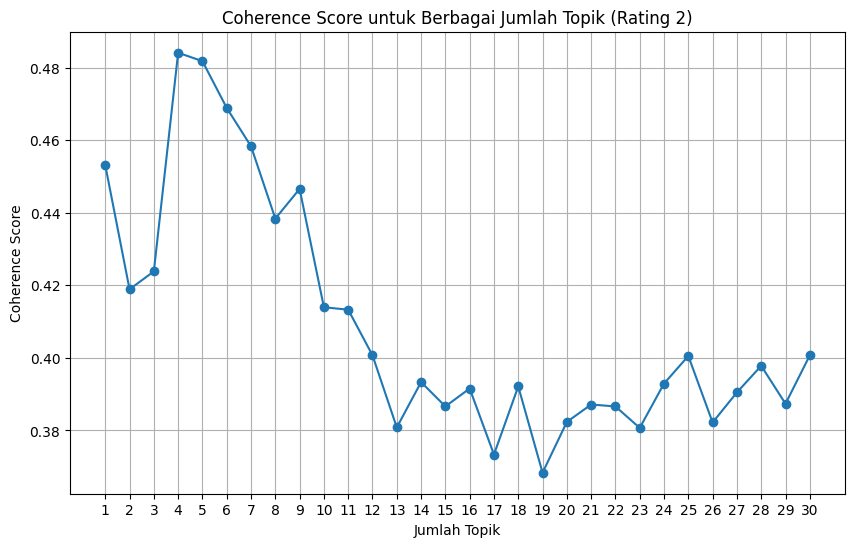

Jumlah Topik Optimal untuk Rating 2: 4 dengan Coherence Score: 0.4841465648856591
Proses untuk Rating 4
Rating: 4, Jumlah Topik: 1, Coherence Score: 0.390129384150145
Rating: 4, Jumlah Topik: 2, Coherence Score: 0.4829647489335789
Rating: 4, Jumlah Topik: 3, Coherence Score: 0.4526200680703538
Rating: 4, Jumlah Topik: 4, Coherence Score: 0.41314461231018074
Rating: 4, Jumlah Topik: 5, Coherence Score: 0.35970731536138717
Rating: 4, Jumlah Topik: 6, Coherence Score: 0.3480991849779478
Rating: 4, Jumlah Topik: 7, Coherence Score: 0.3548864037582498
Rating: 4, Jumlah Topik: 8, Coherence Score: 0.3570852496144229
Rating: 4, Jumlah Topik: 9, Coherence Score: 0.3647306008914547
Rating: 4, Jumlah Topik: 10, Coherence Score: 0.35490547867627364
Rating: 4, Jumlah Topik: 11, Coherence Score: 0.3684287488019264
Rating: 4, Jumlah Topik: 12, Coherence Score: 0.38842279432252597


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 4, Jumlah Topik: 13, Coherence Score: 0.38714911530391105
Rating: 4, Jumlah Topik: 14, Coherence Score: 0.36124064962879804
Rating: 4, Jumlah Topik: 15, Coherence Score: 0.3648791514764213


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 4, Jumlah Topik: 16, Coherence Score: 0.3817324465826093
Rating: 4, Jumlah Topik: 17, Coherence Score: 0.3725141102019362
Rating: 4, Jumlah Topik: 18, Coherence Score: 0.3841347546642384
Rating: 4, Jumlah Topik: 19, Coherence Score: 0.38592893249530247
Rating: 4, Jumlah Topik: 20, Coherence Score: 0.3780446003471384


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 4, Jumlah Topik: 21, Coherence Score: 0.37506845417095175
Rating: 4, Jumlah Topik: 22, Coherence Score: 0.3811054460167652
Rating: 4, Jumlah Topik: 23, Coherence Score: 0.3817853077326749


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Rating: 4, Jumlah Topik: 24, Coherence Score: 0.37577969023899405
Rating: 4, Jumlah Topik: 25, Coherence Score: 0.3817009218977756
Rating: 4, Jumlah Topik: 26, Coherence Score: 0.3792488997498765
Rating: 4, Jumlah Topik: 27, Coherence Score: 0.37199990041852143
Rating: 4, Jumlah Topik: 28, Coherence Score: 0.38258168930366027
Rating: 4, Jumlah Topik: 29, Coherence Score: 0.38374345731745063
Rating: 4, Jumlah Topik: 30, Coherence Score: 0.387746386941536


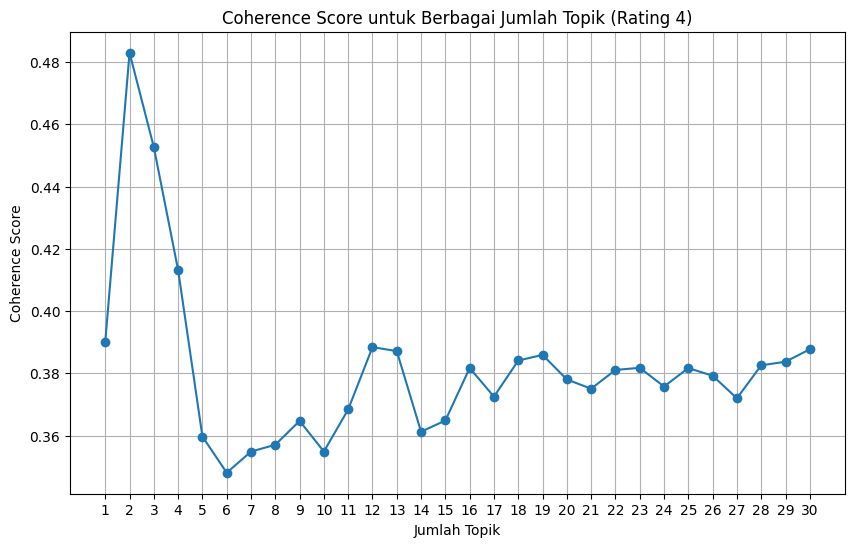

Jumlah Topik Optimal untuk Rating 4: 2 dengan Coherence Score: 0.4829647489335789


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import CoherenceModel
from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')

# Mengelompokkan ulasan berdasarkan rating
ratings = df['rating'].unique()
df['ulasan'] = df['ulasan'].astype(str)

# Proses per rating
for rating in ratings:
    print(f"Proses untuk Rating {rating}")

    # Memfilter ulasan berdasarkan rating
    df_rating = df[df['rating'] == rating]

    # Tokenisasi
    texts = df_rating['ulasan'].dropna().astype(str).tolist()
    tokenized_reviews = [text.split() for text in texts]

    # Menggunakan TfidfVectorizer untuk mendapatkan representasi dokumen
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)

    # Membuat dictionary dari ulasan tokenized
    dictionary = corpora.Dictionary(tokenized_reviews)

    # Mencari jumlah topik optimal menggunakan coherence score
    coherence_scores = []
    topic_range = range(1, 31)

    for num_topics in topic_range:
        # Membuat model NMF
        nmf_model = NMF(n_components=num_topics, random_state=42)
        W = nmf_model.fit_transform(tfidf_matrix)
        H = nmf_model.components_

        # Mendapatkan representasi topik
        features = vectorizer.get_feature_names_out()
        topics = [[features[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in H]

        # Menghitung coherence score
        coherence_model = CoherenceModel(topics=topics, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f'Rating: {rating}, Jumlah Topik: {num_topics}, Coherence Score: {coherence_score}')

    # Visualisasi coherence score
    topics, scores = zip(*coherence_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(topics, scores, marker='o')
    plt.xticks(topics)
    plt.title(f'Coherence Score untuk Berbagai Jumlah Topik (Rating {rating})')
    plt.xlabel('Jumlah Topik')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Menampilkan jumlah topik optimal
    optimal_topics = max(coherence_scores, key=lambda x: x[1])
    print(f'Jumlah Topik Optimal untuk Rating {rating}: {optimal_topics[0]} dengan Coherence Score: {optimal_topics[1]}')


Bert Per Rating

Saving whatsapp_appstore.csv to whatsapp_appstore (5).csv
Proses untuk Rating 3
Rating: 3, Jumlah Topik: 1, Coherence Score: 0.3981948713304734
Rating: 3, Jumlah Topik: 2, Coherence Score: 0.4139876398104843
Rating: 3, Jumlah Topik: 3, Coherence Score: 0.36150330400546854
Rating: 3, Jumlah Topik: 4, Coherence Score: 0.3546392053400843
Rating: 3, Jumlah Topik: 5, Coherence Score: 0.3649455157591032
Rating: 3, Jumlah Topik: 6, Coherence Score: 0.32955612854846955
Rating: 3, Jumlah Topik: 7, Coherence Score: 0.3373273498216844
Rating: 3, Jumlah Topik: 8, Coherence Score: 0.3614272209225899
Rating: 3, Jumlah Topik: 9, Coherence Score: 0.3550660360220923
Rating: 3, Jumlah Topik: 10, Coherence Score: 0.342744007100741
Rating: 3, Jumlah Topik: 11, Coherence Score: 0.31270875463242676
Rating: 3, Jumlah Topik: 12, Coherence Score: 0.32002082635242796
Rating: 3, Jumlah Topik: 13, Coherence Score: 0.32870998819357544
Rating: 3, Jumlah Topik: 14, Coherence Score: 0.3223276605046933
Rating: 3, Juml

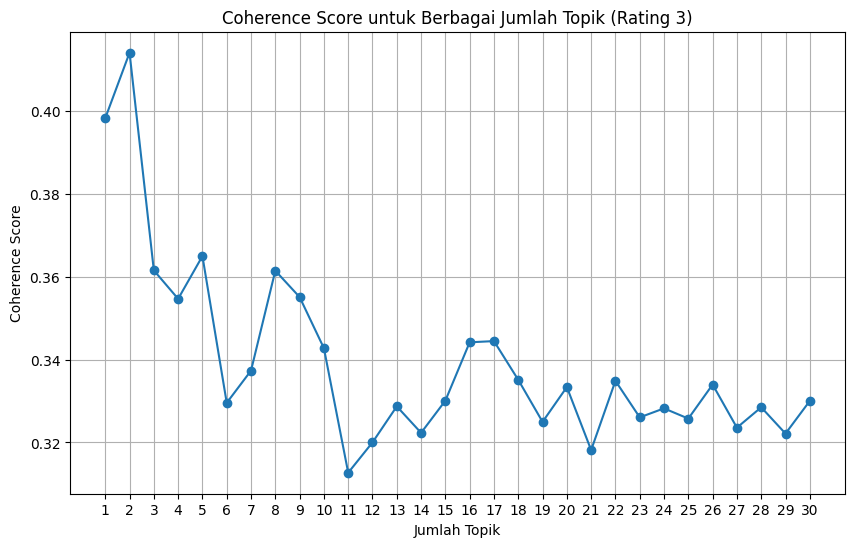

Jumlah Topik Optimal untuk Rating 3: 2 dengan Coherence Score: 0.4139876398104843
Proses untuk Rating 1
Rating: 1, Jumlah Topik: 1, Coherence Score: 0.3671415308568018
Rating: 1, Jumlah Topik: 2, Coherence Score: 0.35027750205881736
Rating: 1, Jumlah Topik: 3, Coherence Score: 0.3123329012469828
Rating: 1, Jumlah Topik: 4, Coherence Score: 0.3073527281284127
Rating: 1, Jumlah Topik: 5, Coherence Score: 0.3130056105619974
Rating: 1, Jumlah Topik: 6, Coherence Score: 0.30842737435118267
Rating: 1, Jumlah Topik: 7, Coherence Score: 0.37833597726708923
Rating: 1, Jumlah Topik: 8, Coherence Score: 0.37974237494092056
Rating: 1, Jumlah Topik: 9, Coherence Score: 0.392239160060026
Rating: 1, Jumlah Topik: 10, Coherence Score: 0.39208524744158624
Rating: 1, Jumlah Topik: 11, Coherence Score: 0.3720479303108442
Rating: 1, Jumlah Topik: 12, Coherence Score: 0.36413568626457354
Rating: 1, Jumlah Topik: 13, Coherence Score: 0.37101643933773837
Rating: 1, Jumlah Topik: 14, Coherence Score: 0.385346

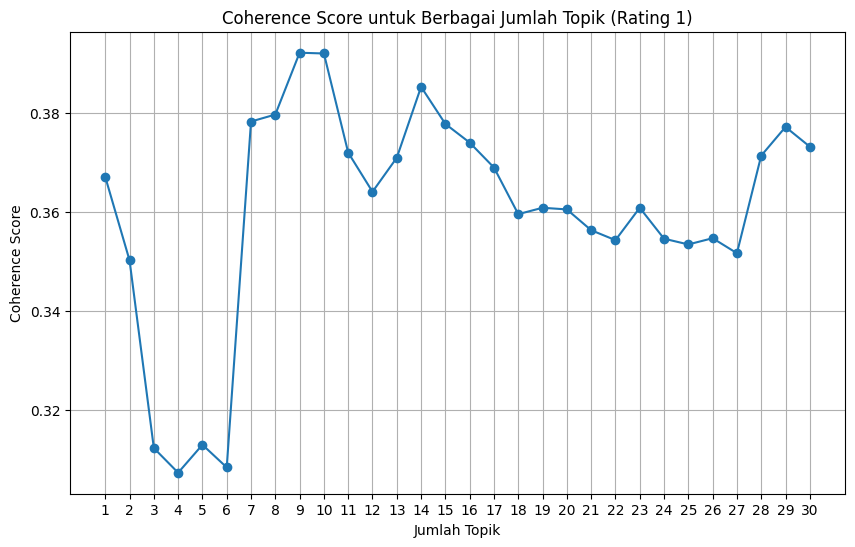

Jumlah Topik Optimal untuk Rating 1: 9 dengan Coherence Score: 0.392239160060026
Proses untuk Rating 5
Rating: 5, Jumlah Topik: 1, Coherence Score: 0.5090009798524403
Rating: 5, Jumlah Topik: 2, Coherence Score: 0.4396953708580177
Rating: 5, Jumlah Topik: 3, Coherence Score: 0.542944068175862
Rating: 5, Jumlah Topik: 4, Coherence Score: 0.5386934381423949
Rating: 5, Jumlah Topik: 5, Coherence Score: 0.5547718173385487
Rating: 5, Jumlah Topik: 6, Coherence Score: 0.5306396558365168
Rating: 5, Jumlah Topik: 7, Coherence Score: 0.4990843385160881
Rating: 5, Jumlah Topik: 8, Coherence Score: 0.5213417158224012
Rating: 5, Jumlah Topik: 9, Coherence Score: 0.5346525513119489
Rating: 5, Jumlah Topik: 10, Coherence Score: 0.5544440428234864
Rating: 5, Jumlah Topik: 11, Coherence Score: 0.5436978719961353
Rating: 5, Jumlah Topik: 12, Coherence Score: 0.5327844318781685
Rating: 5, Jumlah Topik: 13, Coherence Score: 0.5255415361950981
Rating: 5, Jumlah Topik: 14, Coherence Score: 0.50981235307064

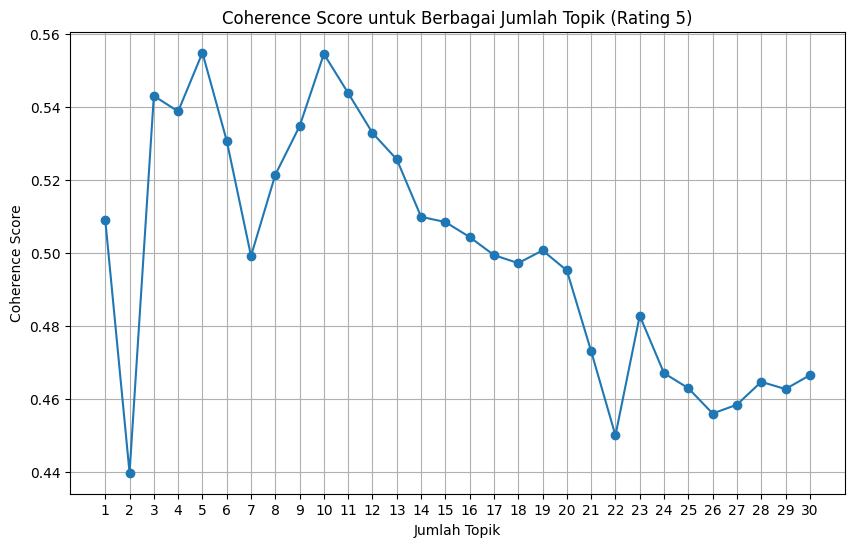

Jumlah Topik Optimal untuk Rating 5: 5 dengan Coherence Score: 0.5547718173385487
Proses untuk Rating 2
Rating: 2, Jumlah Topik: 1, Coherence Score: 0.37945817473247784
Rating: 2, Jumlah Topik: 2, Coherence Score: 0.28749089058453253
Rating: 2, Jumlah Topik: 3, Coherence Score: 0.34107442925309367
Rating: 2, Jumlah Topik: 4, Coherence Score: 0.33819809779804266
Rating: 2, Jumlah Topik: 5, Coherence Score: 0.35058131257624414
Rating: 2, Jumlah Topik: 6, Coherence Score: 0.33059413438979557
Rating: 2, Jumlah Topik: 7, Coherence Score: 0.35231817090713446
Rating: 2, Jumlah Topik: 8, Coherence Score: 0.3305644328972643
Rating: 2, Jumlah Topik: 9, Coherence Score: 0.31434841196313124
Rating: 2, Jumlah Topik: 10, Coherence Score: 0.33151876576567035
Rating: 2, Jumlah Topik: 11, Coherence Score: 0.3215966520216649
Rating: 2, Jumlah Topik: 12, Coherence Score: 0.33084875399805863
Rating: 2, Jumlah Topik: 13, Coherence Score: 0.30619808568864637
Rating: 2, Jumlah Topik: 14, Coherence Score: 0.3

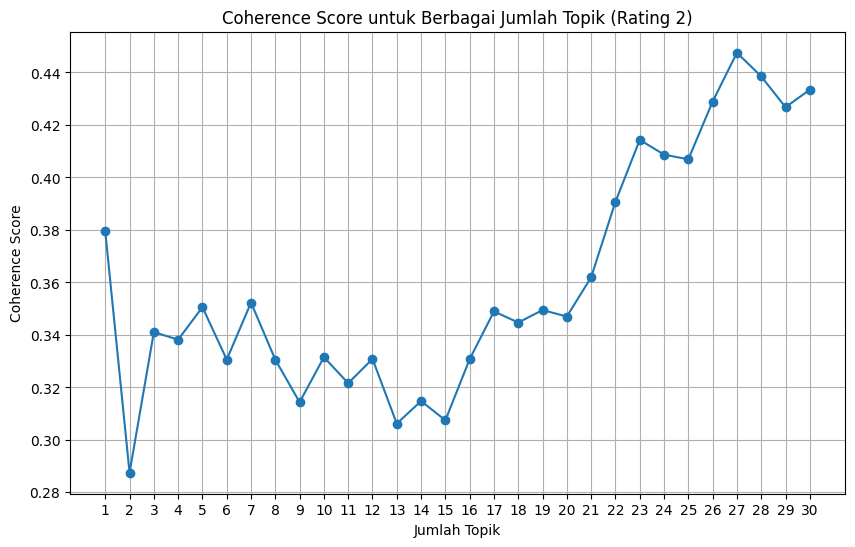

Jumlah Topik Optimal untuk Rating 2: 27 dengan Coherence Score: 0.44752876387875273
Proses untuk Rating 4
Rating: 4, Jumlah Topik: 1, Coherence Score: 0.44214897451750135
Rating: 4, Jumlah Topik: 2, Coherence Score: 0.34394532953996726
Rating: 4, Jumlah Topik: 3, Coherence Score: 0.3463773720574857
Rating: 4, Jumlah Topik: 4, Coherence Score: 0.3676113464113383
Rating: 4, Jumlah Topik: 5, Coherence Score: 0.34558342218898075
Rating: 4, Jumlah Topik: 6, Coherence Score: 0.3593970975927385
Rating: 4, Jumlah Topik: 7, Coherence Score: 0.3792781550794258
Rating: 4, Jumlah Topik: 8, Coherence Score: 0.35891388633228394
Rating: 4, Jumlah Topik: 9, Coherence Score: 0.3741071971735087
Rating: 4, Jumlah Topik: 10, Coherence Score: 0.3596129358304857
Rating: 4, Jumlah Topik: 11, Coherence Score: 0.3624939667136483
Rating: 4, Jumlah Topik: 12, Coherence Score: 0.36703758437511086
Rating: 4, Jumlah Topik: 13, Coherence Score: 0.3662404218364608
Rating: 4, Jumlah Topik: 14, Coherence Score: 0.38815

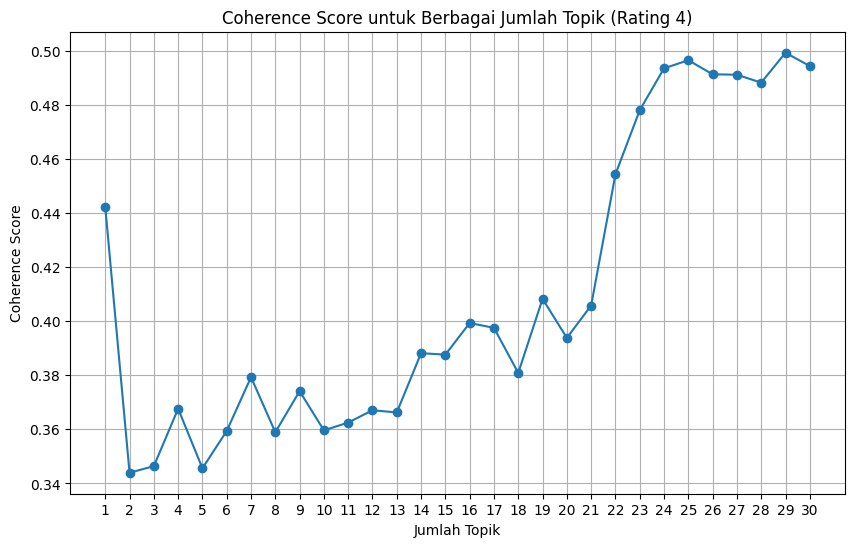

Jumlah Topik Optimal untuk Rating 4: 29 dengan Coherence Score: 0.4992403325420485


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from gensim import corpora
from gensim.models import CoherenceModel
from collections import Counter
from google.colab import files

# Mengunggah file
uploaded = files.upload()

# Membaca file CSV
df = pd.read_csv('whatsapp_appstore.csv')

# Mengelompokkan ulasan berdasarkan rating
ratings = df['rating'].unique()
df['ulasan'] = df['ulasan'].astype(str)

# Menggunakan model BERT untuk embedding
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Proses per rating
for rating in ratings:
    print(f"Proses untuk Rating {rating}")

    # Memfilter ulasan berdasarkan rating
    df_rating = df[df['rating'] == rating]

    # Tokenisasi
    texts = df_rating['ulasan'].dropna().astype(str).tolist()
    tokenized_reviews = [text.split() for text in texts]

    # Mendapatkan embedding menggunakan BERT
    embeddings = model.encode(texts)

    # Membuat dictionary dari ulasan tokenized
    dictionary = corpora.Dictionary(tokenized_reviews)

    # Mencari jumlah cluster optimal menggunakan coherence score
    coherence_scores = []
    topic_range = range(1, 31)

    for num_topics in topic_range:
        # Menggunakan KMeans untuk clustering
        kmeans_model = KMeans(n_clusters=num_topics, random_state=42)
        kmeans_model.fit(embeddings)

        # Mendapatkan representasi topik dengan menghitung kata yang paling sering muncul di setiap cluster
        cluster_assignments = kmeans_model.labels_
        topics = [[] for _ in range(num_topics)]

        for idx, label in enumerate(cluster_assignments):
            topics[label].extend(tokenized_reviews[idx])

        # Pilih 10 kata paling sering dari setiap topik
        top_words_per_topic = []
        for topic in topics:
            word_counts = Counter(topic)
            top_words = [word for word, _ in word_counts.most_common(10)]
            top_words_per_topic.append(top_words)

        # Menghitung coherence score menggunakan dictionary
        coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f'Rating: {rating}, Jumlah Topik: {num_topics}, Coherence Score: {coherence_score}')

    # Visualisasi coherence score
    topics, scores = zip(*coherence_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(topics, scores, marker='o')
    plt.xticks(topics)
    plt.title(f'Coherence Score untuk Berbagai Jumlah Topik (Rating {rating})')
    plt.xlabel('Jumlah Topik')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

    # Menampilkan jumlah topik optimal
    optimal_topics = max(coherence_scores, key=lambda x: x[1])
    print(f'Jumlah Topik Optimal untuk Rating {rating}: {optimal_topics[0]} dengan Coherence Score: {optimal_topics[1]}')
